### [Sequence Models](https://youtu.be/S7oA5C43Rbc?si=e_6chxscLpNwXvBX)

In [178]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [179]:
df = pd.read_csv('temp.csv')
data = torch.tensor(df['Temperature (C)'].values, dtype=torch.float32)
data.shape

torch.Size([96453])

In [180]:
data = data.view(-1, 1) # add 1 dimension y
data.shape

torch.Size([96453, 1])

### RNN Model
batch - sequence_length - features

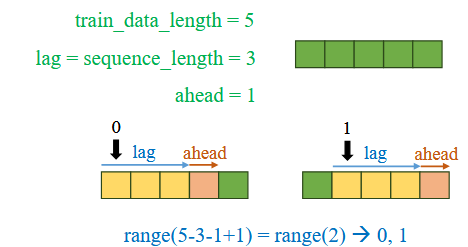

In [181]:
def create_sequence(data, lag=3, ahead=1):
    #? Choose number of input sample:prediction ratio. 3:1 mean every sample use sequence of 3 to predict 1 datapoint
    X, y = [], []
    for i in range(len(data) - lag - ahead + 1):
        X.append(data[i: i+lag]) # number of sample each sequence
        y.append(data[i+lag: i+lag+ahead]) # number of future prediction

    return np.array(X), np.array(y)

sequence = create_sequence(data)

print("X shape:", sequence[0].shape) # (count, row, col)
print("y shape:", sequence[1].shape) # (count, row, col)

X shape: (96450, 3, 1)
y shape: (96450, 1, 1)


In [182]:
def prepare_data(data, lag, ahead, batch_size, train_ratio=0.7):
    X, y = create_sequence(data, lag, ahead)

    train_size = int(len(data) * train_ratio)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    train_data = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

    # load train and test seperately
    return train_loader, X_test_tensor, y_test_tensor


In [183]:
train_loader, _, _ = prepare_data(data, lag=5, ahead=1, batch_size=12, train_ratio=0.7)
# print(X_test_tensor[0].shape)

In [184]:
m = torch.zeros((2,2))
print(m, "\n")
n = m.view(-1, 2) # flatten
print(n)

tensor([[0., 0.],
        [0., 0.]]) 

tensor([[0., 0.],
        [0., 0.]])


In [185]:
def train_model(model, criterion, optimizer, train_loader, num_epochs):
    losses = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (sequences, labels) in enumerate(train_loader):
            # Forward pass
            print('SHAPE:', sequences.shape)
            outputs = model(sequences) #!
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad() # clear all gradient in this iter, Prevent gradient accumulation
            loss.backward() # backpropagation
            optimizer.step() # update

            running_loss+=loss.item()

        epoch_loss = running_loss / len(train_loader)
        losses.append(running_loss)
        print(f"Epoch {epoch+1}/{num_epochs} - Loss {epoch_loss:.4f}")

    return model, losses


def evaluate_model(model, X_test_tensor, y_test_tensor,ahead):
    # Switch into evaluation model (switch to testing module)
    # ensure dropout, batchnorm, and gradient behave correctly
    model.eval()

    with torch.no_grad(): # turn off gradient Tracking, reduce memory usage
        pred = model(X_test_tensor)
        #? view() reshape tensor without copy&paste them into new shape molt
        pred = pred.view(-1, ahead).numpy() # reshape prediction (row, col) where -1 mean all
        y_test = y_test_tensor.numpy()
        print(f'{pred.shape}')
        print(f'{y_test.shape}')

        r2 = r2_score(y_test, pred)
        mae = mean_absolute_error(y_test, pred)
        mse = mean_absolute_error(y_test, pred)

    print(f'R2 Score {r2}')
    print(f'MSE Score {mse}')
    print(f'MAE Score {mae}')

    return r2, mse, mae


def plot_training_loss(losses):
    plt.plot(losses, label="training losses")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()

In [186]:
num_epochs = 20
train_ratio = 0.8
batch_size = 64
lr = 0.001
lag = 10
ahead = 1
hidden_dim = 32

In [187]:
# initia model
class RNNModel(nn.Module):
    def __init__(self, hidden_dim, output_dim):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(1, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        output_rnn, hidden_rnn = self.rnn(x)
        last_hidden = hidden_rnn[-1, :, :] # flatten
        output = self.fc(last_hidden)

        return output

In [188]:
# preapare data
train_loader, X_test_tensor, y_test_tensor = prepare_data(data, lag, ahead, batch_size, train_ratio=0.7)

# train model
model = RNNModel(hidden_dim=2, output_dim=1)
model

RNNModel(
  (rnn): RNN(1, 2, batch_first=True)
  (fc): Linear(in_features=2, out_features=1, bias=True)
)

In [189]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model, losses = train_model(model, criterion, optimizer, train_loader, num_epochs=20)

SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: t

c:\Users\ACER\anaconda3\envs\new\lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([64, 1, 1])) that is different to the input size (torch.Size([64, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: t

c:\Users\ACER\anaconda3\envs\new\lib\site-packages\torch\nn\modules\loss.py:634: UserWarning: Using a target size (torch.Size([61, 1, 1])) that is different to the input size (torch.Size([61, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: torch.Size([64, 10, 1])
SHAPE: t

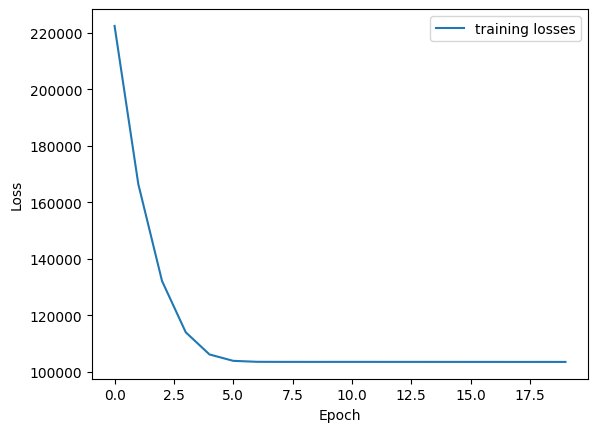

In [190]:
plot_training_loss(losses)